In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn import metrics
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#read in train/test/valid
train = pd.read_csv('..\\partition\\train.csv')
valid = pd.read_csv('..\\partition\\valid.csv')
test = pd.read_csv('..\\partition\\test.csv')

### Set up the variables for modeling

In [3]:
# Race and Country are excluded as they don't appear important according to the exploratory analysis
# excluded education_level as it measures the same thing as education_num
# create dummy vars for marital_status, occupation, workclass, and sex 

#train
y_train, x_train = dmatrices('over_50k ~ C(workclass) + C(marital_status) + C(occupation) + C(sex) + age + education_num + capital_gain+ capital_loss + hours_week',
                       train,return_type="dataframe")
y_train = np.ravel(y_train)

#valid
y_valid, x_valid = dmatrices('over_50k ~ C(workclass) + C(marital_status) + C(occupation) + C(sex) + age + education_num + capital_gain+ capital_loss + hours_week',
                       valid,return_type="dataframe")
y_valid = np.ravel(y_valid)

#test
y_test, x_test = dmatrices('over_50k ~ C(workclass) + C(marital_status) + C(occupation) + C(sex) + age + education_num + capital_gain+ capital_loss + hours_week',
                       test,return_type="dataframe")
y_test = np.ravel(y_test)

In [4]:
x_train.tail()


,Intercept,C(workclass)[T.Federal-gov],C(workclass)[T.Local-gov],C(workclass)[T.Never-worked],C(workclass)[T.Private],C(workclass)[T.Self-emp-inc],C(workclass)[T.Self-emp-not-inc],C(workclass)[T.State-gov],C(workclass)[T.Without-pay],C(marital_status)[T.Married-AF-spouse],...,C(occupation)[T.Protective-serv],C(occupation)[T.Sales],C(occupation)[T.Tech-support],C(occupation)[T.Transport-moving],C(sex)[T.Male],age,education_num,capital_gain,capital_loss,hours_week
29300,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,48.0,9.0,0.0,0.0,40.0
29301,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,30.0,9.0,0.0,0.0,35.0
29302,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,35.0,10.0,0.0,0.0,60.0
29303,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0,45.0
29304,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,42.0,9.0,0.0,0.0,8.0


### First stab at a logistic model with just numeric vars

In [5]:
#first stab with just numeric variables
y_num_train, x_num_train = dmatrices('over_50k ~ age + education_num + capital_gain + capital_loss + hours_week',
                       train,return_type="dataframe")
y_num_train = np.ravel(y_num_train)

In [6]:
x_num_train.head()

,Intercept,age,education_num,capital_gain,capital_loss,hours_week
0,1.0,22.0,10.0,0.0,0.0,30.0
1,1.0,43.0,16.0,0.0,0.0,40.0
2,1.0,45.0,13.0,0.0,0.0,40.0
3,1.0,41.0,9.0,0.0,0.0,45.0
4,1.0,56.0,9.0,0.0,0.0,40.0


In [7]:
# run a logistic regression on the numeric vars
logreg1 = LogisticRegression(tol=.00000001,max_iter=500)

# fit log. model
logreg1.fit(x_num_train , y_num_train)

# generate Probabilities for over_50k
probs1 = logreg1.predict_proba(x_num_train)[:,1]

# creating a coefficients table
coeff =  logreg1.coef_
pred_vars = list(x_num_train)
coeff_dict = dict(zip(pred_vars, *coeff))
coeff_table = pd.DataFrame(pd.Series(coeff_dict), columns=['coeff'])

# print notes, print AUC
print "AUC:", metrics.roc_auc_score(y_num_train, probs1)
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: none'
coeff_table

AUC: 0.830687411976
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: none


,coeff
Intercept,-4.090751
age,0.040917
capital_gain,0.000324
capital_loss,0.000687
education_num,0.322186
hours_week,0.039420


### Rank vars with RFE

In [8]:
#Recursive feature elimination on categorical vars

#drop other vars
x_train_rfe = x_train.drop(['Intercept','age','education_num','capital_gain','capital_loss', 'hours_week'], axis=1)

features = list(x_train_rfe) 
#use logistic regression 
logr = LogisticRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(logr, n_features_to_select=1)
rfe.fit(x_train_rfe,y_train)
#match rankings to features and print
ranks = list(rfe.ranking_)
rankings = pd.DataFrame(
    {'feature': features,
     'rank': ranks,
    })
print rankings.sort(['rank'])

# somewhat confirms the exploratory analysis
# marital_status and occupation rank above sex and workclass
# but we'll train on all 4 of them with the numeric vars to see performance

                                       feature  rank
9      C(marital_status)[T.Married-civ-spouse]     1
8       C(marital_status)[T.Married-AF-spouse]     2
23             C(occupation)[T.Prof-specialty]     3
17            C(occupation)[T.Exec-managerial]     4
22            C(occupation)[T.Priv-house-serv]     5
21              C(occupation)[T.Other-service]     6
19          C(occupation)[T.Handlers-cleaners]     7
7                  C(workclass)[T.Without-pay]     8
18            C(occupation)[T.Farming-fishing]     9
26               C(occupation)[T.Tech-support]    10
25                      C(occupation)[T.Sales]    11
0                  C(workclass)[T.Federal-gov]    12
11          C(marital_status)[T.Never-married]    13
4                 C(workclass)[T.Self-emp-inc]    14
24            C(occupation)[T.Protective-serv]    15
15               C(occupation)[T.Armed-Forces]    16
20          C(occupation)[T.Machine-op-inspct]    17
28                              C(sex)[T.Male]

C:\Users\Doug\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Logistic model (with categorical vars included)

In [9]:
# set up Logistic model function
# vars include: age, education_num, capital_gain, capital_loss, hours_week, marital_status, occupation, sex, workclass

def log_reg(preds, target):
    #run logistic model
    logreg_train = LogisticRegression(tol=.00000001,max_iter=500)
    #Fit logistic model
    logreg_train.fit(preds , target)

    #prettifying the parameters/coefficients table
    coeff =  logreg_train.coef_
    pred_vars = list(preds)
    coeff_dict = dict(zip(pred_vars, *coeff))
    full_coeff = pd.DataFrame(pd.Series(coeff_dict), columns=['coeff'])

    #generate Probabilities for over_50k
    probs_train = logreg_train.predict_proba(preds)[:,1]

    #printing notes and coeff dataframe
    print "AUC:", metrics.roc_auc_score(target, probs_train)
    print 'No. of Parameters:', len(full_coeff)
    print 'Intercept: ', logreg_train.intercept_
    return full_coeff

print 'Test'
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass' 
log_reg(x_train, y_train) 
# improvement in AUC

Test
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
AUC: 0.906882195581
No. of Parameters: 35
Intercept:  [-4.38318556]


,coeff
C(marital_status)[T.Married-AF-spouse],1.887022
C(marital_status)[T.Married-civ-spouse],2.248967
C(marital_status)[T.Married-spouse-absent],-0.110451
C(marital_status)[T.Never-married],-0.512645
C(marital_status)[T.Separated],0.082946
C(marital_status)[T.Widowed],0.050423
C(occupation)[T.Adm-clerical],0.267215
C(occupation)[T.Armed-Forces],0.377651
C(occupation)[T.Craft-repair],0.306650
C(occupation)[T.Exec-managerial],1.077332


### Running on Validation Set

In [10]:
#VALIDATION
print 'Validation'
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass' 
log_reg(x_valid, y_valid)

Validation
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
AUC: 0.900683752617
No. of Parameters: 35
Intercept:  [-4.33903883]


,coeff
C(marital_status)[T.Married-AF-spouse],1.258702
C(marital_status)[T.Married-civ-spouse],2.167561
C(marital_status)[T.Married-spouse-absent],0.311036
C(marital_status)[T.Never-married],-0.416184
C(marital_status)[T.Separated],-0.362272
C(marital_status)[T.Widowed],-0.281473
C(occupation)[T.Adm-clerical],0.229837
C(occupation)[T.Armed-Forces],-0.193871
C(occupation)[T.Craft-repair],0.264747
C(occupation)[T.Exec-managerial],0.986692


### Creating a new feature (just for fun)
See if salaried employees can be teased out of hour_week feature

In [11]:
# Bin hours_week so that we isolate 40, 45, 50, and 60 hour work weeks
# Perhaps these individuals are salaried if they are reporting 'round' hours/week
# it might help to predict higher incomes

# create cutoff values
# create a label for the cutoffs
hrs_9_bins = [0, 39.5, 40.5, 44.5, 45.5, 49.5, 50.5, 59.5, 60.5, 99.0]
hrs_9bins_labels = ['<40','40','41-44','45','46-49','50','51-59','60','61-100']

In [12]:
# cut hours_week and create a new column
train['hrs_salaried'] = pd.cut(train['hours_week'], hrs_9_bins, labels=hrs_9bins_labels)
valid['hrs_salaried'] = pd.cut(valid['hours_week'], hrs_9_bins, labels=hrs_9bins_labels)
test['hrs_salaried'] = pd.cut(test['hours_week'], hrs_9_bins, labels=hrs_9bins_labels)

#count the number of obs in each bin
pd.value_counts(train['hrs_salaried'])

40        13670
<40        7088
50         2516
45         1638
60         1307
61-100     1003
51-59       937
46-49       594
41-44       552
Name: hrs_salaried, dtype: int64

In [13]:
# Creating another feature with fewer bins
# Group anything not 40, 45, 50, or 60 into an all else category

#train
train['hrs_salaried_5'] = train['hrs_salaried']
train['hrs_salaried_5'] = train['hrs_salaried_5'].map({'40': '40', '<40': 'other','50': '50','45': '45','60': '60',
                                              '61-100': 'other', '51-59': 'other','46-49': 'other','41-44': 'other',})
#valid
valid['hrs_salaried_5'] = valid['hrs_salaried']
valid['hrs_salaried_5'] = valid['hrs_salaried_5'].map({'40': '40', '<40': 'other','50': '50','45': '45','60': '60',
                                              '61-100': 'other', '51-59': 'other','46-49': 'other','41-44': 'other',})
#test
test['hrs_salaried_5'] = test['hrs_salaried']
test['hrs_salaried_5'] = test['hrs_salaried_5'].map({'40': '40', '<40': 'other','50': '50','45': '45','60': '60',
                                              '61-100': 'other', '51-59': 'other','46-49': 'other','41-44': 'other',})

pd.value_counts(train['hrs_salaried_5'])

40       13670
other    10174
50        2516
45        1638
60        1307
Name: hrs_salaried_5, dtype: int64

In [14]:
#Putting this binned variable inthe model
#'other' is the treatment value

#training, with just the 5 bins for hours_week C(Location, Treatment(reference='China')
y_train, x_train = dmatrices('over_50k ~ C(workclass) + C(marital_status) + C(occupation) + C(sex) + C(hrs_salaried_5, Treatment(reference="other")) + age + education_num + capital_gain+ capital_loss + hours_week',
                       train,return_type="dataframe")
y_train = np.ravel(y_train)

#valid, with the 5 bins for hours_week
y_valid, x_valid = dmatrices('over_50k ~ C(workclass) + C(marital_status) + C(occupation) + C(sex) + C(hrs_salaried_5, Treatment(reference="other")) + age + education_num + capital_gain+ capital_loss + hours_week',
                       valid,return_type="dataframe")
y_valid = np.ravel(y_valid)

#test, with the 5 bins for hours_week
y_test, x_test = dmatrices('over_50k ~ C(workclass) + C(marital_status) + C(occupation) + C(sex) + C(hrs_salaried_5, Treatment(reference="other")) + age + education_num + capital_gain+ capital_loss + hours_week',
                       test,return_type="dataframe")
y_test = np.ravel(y_test)

In [15]:
#Run the logistic model on training
print 'Test'
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass' 
log_reg(x_train, y_train)
# training AUC in champion model: 0.906882195581
# with binned hours_week varaible: 0.907454504622
# very, very slight improvement on training

Test
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
AUC: 0.907454504622
No. of Parameters: 39
Intercept:  [-4.40030295]


,coeff
"C(hrs_salaried_5, Treatment(reference=""other""))[T.40]",0.156137
"C(hrs_salaried_5, Treatment(reference=""other""))[T.45]",0.385923
"C(hrs_salaried_5, Treatment(reference=""other""))[T.50]",0.482809
"C(hrs_salaried_5, Treatment(reference=""other""))[T.60]",0.128054
C(marital_status)[T.Married-AF-spouse],1.964333
C(marital_status)[T.Married-civ-spouse],2.258811
C(marital_status)[T.Married-spouse-absent],-0.091105
C(marital_status)[T.Never-married],-0.499777
C(marital_status)[T.Separated],0.095772
C(marital_status)[T.Widowed],0.074054


In [16]:
#validation
print 'Validation'
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass' 
log_reg(x_valid, y_valid)
# validation AUC in previous model: 0.900683752617
# with binned hours_week varaible: 0.901337268177

Validation
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
AUC: 0.901337268177
No. of Parameters: 39
Intercept:  [-4.40487607]


,coeff
"C(hrs_salaried_5, Treatment(reference=""other""))[T.40]",0.225408
"C(hrs_salaried_5, Treatment(reference=""other""))[T.45]",0.381463
"C(hrs_salaried_5, Treatment(reference=""other""))[T.50]",0.451395
"C(hrs_salaried_5, Treatment(reference=""other""))[T.60]",0.074877
C(marital_status)[T.Married-AF-spouse],1.237212
C(marital_status)[T.Married-civ-spouse],2.182701
C(marital_status)[T.Married-spouse-absent],0.342490
C(marital_status)[T.Never-married],-0.401929
C(marital_status)[T.Separated],-0.350882
C(marital_status)[T.Widowed],-0.255209


In [17]:
#Run this model on Test
print  'Test'
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass' 
log_reg(x_test, y_test)

Test
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
AUC: 0.905288876345
No. of Parameters: 39
Intercept:  [-3.9430427]


,coeff
"C(hrs_salaried_5, Treatment(reference=""other""))[T.40]",0.059129
"C(hrs_salaried_5, Treatment(reference=""other""))[T.45]",0.515756
"C(hrs_salaried_5, Treatment(reference=""other""))[T.50]",0.644978
"C(hrs_salaried_5, Treatment(reference=""other""))[T.60]",-0.004340
C(marital_status)[T.Married-AF-spouse],1.861631
C(marital_status)[T.Married-civ-spouse],1.864793
C(marital_status)[T.Married-spouse-absent],0.405229
C(marital_status)[T.Never-married],-0.782984
C(marital_status)[T.Separated],-0.862578
C(marital_status)[T.Widowed],-0.420026


### Plotting train/valid/test on a ROC Curve

These curves show the model with the binned hour_week variable

In [18]:
# ROC CURVE

#Get probs from training 
model_train = LogisticRegression(tol=.00000001,max_iter=500)
model_train.fit(x_train, y_train)
#get probabilities
train_scores = model_train.predict_proba(x_train)[:,1]

#Get probs from validation 
model_valid = LogisticRegression(tol=.00000001,max_iter=500)
model_valid.fit(x_valid, y_valid)
valid_scores = model_valid.predict_proba(x_valid)[:,1]

#Get probs from test
model_test  = LogisticRegression(tol=.00000001,max_iter=500)
model_test.fit(x_test, y_test)
test_scores = model_test.predict_proba(x_test)[:,1]

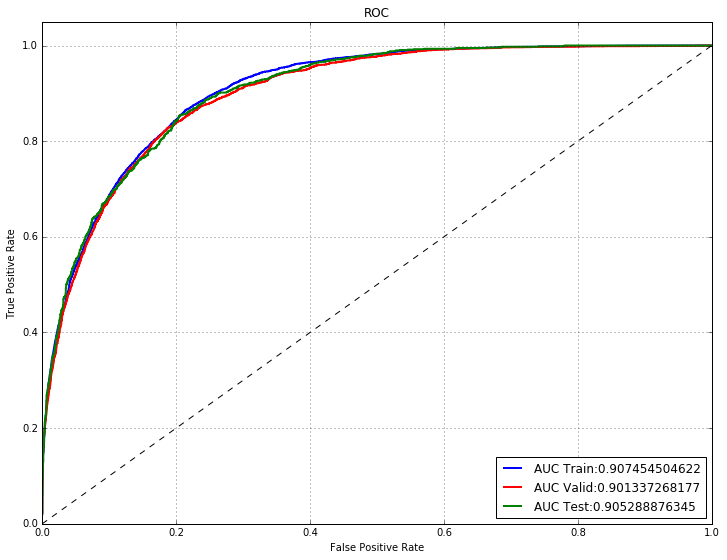

In [19]:
# build the roc curve plot
plt.figure(figsize=(12,9),dpi=600)

#the training curve
fpr, tpr, thresholds = roc_curve(y_train, train_scores)
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="AUC Train:{0}".format(auc1),color='blue', linewidth=2)

#the validation curve
fpr, tpr, thresholds = metrics.roc_curve(y_valid, valid_scores)
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="AUC Valid:{0}".format(auc1),color='red', linewidth=2)

#the validation curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_scores)
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="AUC Test:{0}".format(auc1),color='green', linewidth=2)

#set axis limits
plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

#labels
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")

plt.show()